# Sentiment Analysis of a Telegram Channel with PySpark and Spark NLP

## Summary: 
The current study centers on the analysis of the posts of a Telegram channel with PySpark. In particular, the Huobi Telegram channel is selected, a channel focused on discussing the trading of cryptocurrencies. The employed dataset, **group_messages_huobi.json** has been obtained from https://www.kaggle.com/aagghh/crypto-telegram-groups?select=group_messages_huobi.json, and it contains around 550,000 user posts. The objectives of this study are as follows:
* To analyze each of the fields in the JSON dataset, extracting the number of missing and unique values of each attribute.
* To determine the hours of the day and the days of the week in which the channel is most active.
* To determine what the most frequently mentioned cryptocurrencies are, as well as the evolution of their mentions.
* To compare the evolution of mentions of the most popular cryptocurrencies with their trading price.
* To assign a sentiment value to each of the posts in the dataset, and observe the evolution of the channel's overall sentiment with time. This is to be implemented with a rudimentary sentiment dictionary and with Spark NLP's sentiment classifier.
* To predict the evolution of a relevant cryptocurrency's price based on the vectorized version of each of the channel's posts. This is attempted with a NN via PyTorch and accomplished with Spark NLP's DL classifier.

## 1. PySpark Environment Setup


In [2]:
import os

# Install JDK 8
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install PySpark 2.4.x
! pip install -q pyspark==2.4.7
! pip install -q spark-nlp

#Install other libraries
! pip install findspark
! pip install IPython
! pip install pandas
! pip install matplotlib
! pip install yfinance

openjdk version "1.8.0_282"
OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)
     |████████████████████████████████| 217.9MB 65kB/s 
     |████████████████████████████████| 204kB 52.8MB/s 
     |████████████████████████████████| 143kB 8.4MB/s 
     |████████████████████████████████| 5.5MB 11.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=61e7f47b175c0d3f51ad9de87b358f85dcfac728f0c408fbe227eba537beaf6d
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5").getOrCreate()

In [4]:
from IPython.display import display, Markdown
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [5]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


## 2. Reading the Dataset as a PySpark DataFrame

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = spark.read.json("/content/drive/MyDrive/Spark/Individual Assignment/group_messages_huobi.json", multiLine=True)
df.printSchema()

root
 |-- _: string (nullable = true)
 |-- action: struct (nullable = true)
 |    |-- _: string (nullable = true)
 |    |-- chat_id: long (nullable = true)
 |    |-- game_id: long (nullable = true)
 |    |-- photo: struct (nullable = true)
 |    |    |-- _: string (nullable = true)
 |    |    |-- access_hash: long (nullable = true)
 |    |    |-- date: string (nullable = true)
 |    |    |-- dc_id: long (nullable = true)
 |    |    |-- file_reference: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- has_stickers: boolean (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- sizes: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- _: string (nullable = true)
 |    |    |    |    |-- bytes: array (nullable = true)
 |    |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |    |-- h: long (nullable = true)
 |    |    |    |    |-- location: st

To simplify the analysis, given the long list of attributes in this DataFrame, only the following are employed:
* date: Timestamp representing the time of the message
* message: The post string
* id: An ID for each post
* from_id.user_id: The post's author ID.

Moreover, the dataset is truncated to allow for faster processing.

In [8]:
df = df.select([
    col('id').alias('Post_ID'), 
    col('date').alias('Timestamp'), 
    col('message').alias('Message'), 
    col('from_id.user_id').alias('Author_ID')
]).limit(250000)

df_pure = df
df.limit(10).toPandas()

,Post_ID,Timestamp,Message,Author_ID
0,1018295,2021-01-27T12:18:20+00:00,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.",378862929
1,1018294,2021-01-27T12:15:16+00:00,⚠️ Important Reminder ☠️\n\n🚫 Huobi Global doesn't have any official customer support on Telegram. Admins and Huobi Knights will never ask you to make any form of payment or any personal and account related information for any reason. \n\n⁉️ If you need any kind of assistance related to your account please submit a ticket here (https://huobiglobal.zendesk.com/hc/de/requests/new). We will resolve your issue as soon as possible.,210944655
2,1018293,2021-01-27T11:52:45+00:00,Until when is the Kyc video review?,520934873
3,1018288,2021-01-27T11:42:54+00:00,"Hello there welcome, how may I help you today?",612816754
4,1018287,2021-01-27T11:42:32+00:00,No,612816754
5,1018286,2021-01-27T11:41:18+00:00,Hi guys,1399987656
6,1018281,2021-01-27T11:38:47+00:00,"Hi team, are Huobi cooperate with NEUMEOKCA?",1166637481
7,1018276,2021-01-27T11:32:17+00:00,Huobi team will never call you.\nStay safe,524337332
8,1018275,2021-01-27T11:31:51+00:00,It's a typical scam call MD⚠️⚠️⚠️,524337332
9,1018273,2021-01-27T11:28:38+00:00,"Hi, I got a call from a private number few hours back she was claiming to be from huobi and asked me if I'm still trading crypto and told my huobi account is inactive, wanted to know if it was from huobi or scam call",427029442


## 3. Examining the Number of NaNs and Unique Values in Each Column

In [9]:
print("Checking for nulls on columns Post_ID, Timestamp, Message and Author_ID:")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in ["Post_ID","Timestamp","Message","Author_ID"]]).show()

Checking for nulls on columns Post_ID, Timestamp, Message and Author_ID:
+-------+---------+-------+---------+
|Post_ID|Timestamp|Message|Author_ID|
+-------+---------+-------+---------+
|      0|        0|  31210|      468|
+-------+---------+-------+---------+



In [10]:
print("Checking amount of distinct values in columns Post_ID, Timestamp, Message and Author_ID:")
df.select([countDistinct(c).alias(c) for c in ["Post_ID","Timestamp","Message","Author_ID"]]).show()

Checking amount of distinct values in columns Post_ID, Timestamp, Message and Author_ID:
+-------+---------+-------+---------+
|Post_ID|Timestamp|Message|Author_ID|
+-------+---------+-------+---------+
| 250000|   238729| 134943|    59147|
+-------+---------+-------+---------+



## 4. Determining the Most Active Days of the Week and Hours of the Day

### 4.1 Obtaining auxiliary columns for Date, Day of the Week, and Hour of the Day

In [11]:
df = df\
    .withColumn('Date', to_date(col('Timestamp')))\
    .withColumn('Day_of_Week', dayofweek(col('Timestamp')))\
    .withColumn('Hour_of_Day', hour(col('Timestamp')))\
    .cache()
df.limit(10).toPandas()

,Post_ID,Timestamp,Message,Author_ID,Date,Day_of_Week,Hour_of_Day
0,1018295,2021-01-27T12:18:20+00:00,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.",378862929,2021-01-27,4,12
1,1018294,2021-01-27T12:15:16+00:00,⚠️ Important Reminder ☠️\n\n🚫 Huobi Global doesn't have any official customer support on Telegram. Admins and Huobi Knights will never ask you to make any form of payment or any personal and account related information for any reason. \n\n⁉️ If you need any kind of assistance related to your account please submit a ticket here (https://huobiglobal.zendesk.com/hc/de/requests/new). We will resolve your issue as soon as possible.,210944655,2021-01-27,4,12
2,1018293,2021-01-27T11:52:45+00:00,Until when is the Kyc video review?,520934873,2021-01-27,4,11
3,1018288,2021-01-27T11:42:54+00:00,"Hello there welcome, how may I help you today?",612816754,2021-01-27,4,11
4,1018287,2021-01-27T11:42:32+00:00,No,612816754,2021-01-27,4,11
5,1018286,2021-01-27T11:41:18+00:00,Hi guys,1399987656,2021-01-27,4,11
6,1018281,2021-01-27T11:38:47+00:00,"Hi team, are Huobi cooperate with NEUMEOKCA?",1166637481,2021-01-27,4,11
7,1018276,2021-01-27T11:32:17+00:00,Huobi team will never call you.\nStay safe,524337332,2021-01-27,4,11
8,1018275,2021-01-27T11:31:51+00:00,It's a typical scam call MD⚠️⚠️⚠️,524337332,2021-01-27,4,11
9,1018273,2021-01-27T11:28:38+00:00,"Hi, I got a call from a private number few hours back she was claiming to be from huobi and asked me if I'm still trading crypto and told my huobi account is inactive, wanted to know if it was from huobi or scam call",427029442,2021-01-27,4,11


### 4.2 Examining the temporal extent of the dataset

In [12]:
print("Checking amount of distinct values in columns Post_ID, Date, Day_of_Week and Hour_of_Day:")
df.select([countDistinct(c).alias(c) for c in ["Post_ID","Date","Day_of_Week","Hour_of_Day"]]).show()

Checking amount of distinct values in columns Post_ID, Date, Day_of_Week and Hour_of_Day:
+-------+----+-----------+-----------+
|Post_ID|Date|Day_of_Week|Hour_of_Day|
+-------+----+-----------+-----------+
| 250000| 612|          7|         24|
+-------+----+-----------+-----------+



In [13]:
df.select(expr("MIN(DATE) AS MIN_DATE"), expr("MAX(DATE) AS MAX_DATE")).show()

+----------+----------+
|  MIN_DATE|  MAX_DATE|
+----------+----------+
|2019-05-27|2021-01-27|
+----------+----------+



As we can see, the dataset spans over 612 days, from 2019-05-27 to 2021-01-27.

### 4.3 Obtaining the most active days of the week

In [14]:
summary_week = df.groupBy(col('Day_of_Week')).count().orderBy(col('count').desc()).toPandas()
summary_week

,Day_of_Week,count
0,4,40535
1,3,39792
2,2,38775
3,5,38712
4,6,37886
5,7,28755
6,1,25545


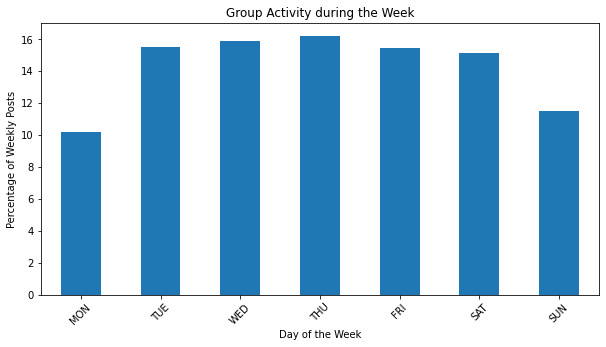

In [15]:
weekday_abbreviations = {4:'THU', 3:'WED', 2:'TUE', 5:'FRI', 6:'SAT', 7:'SUN', 1:'MON'}
total_posts = summary_week['count'].sum()
summary_week\
    .sort_values('Day_of_Week')\
    .replace({'Day_of_Week':weekday_abbreviations})\
    .apply(lambda x: x * 100 / total_posts if x.name == 'count' else x)\
    .plot.bar(x='Day_of_Week', y='count', 
        title='Group Activity during the Week', 
        rot=45,
        xlabel='Day of the Week',
        ylabel='Percentage of Weekly Posts',
        legend=False,
        figsize=(10, 5))

As we can see, **Thursdays** are the most active days of the week for this channel, followed very closely by Wednesdays, Tuesdats, and Fridays.

### 4.4 Obtaining the most active hours of the day

In [16]:
summary_day = df.groupBy(col('Hour_of_Day')).count().orderBy(col('count').desc()).toPandas()
summary_day

,Hour_of_Day,count
0,12,25029
1,13,17864
2,9,14362
3,11,14168
4,10,13643
5,14,13529
6,15,12940
7,8,12763
8,7,11987
9,16,11527


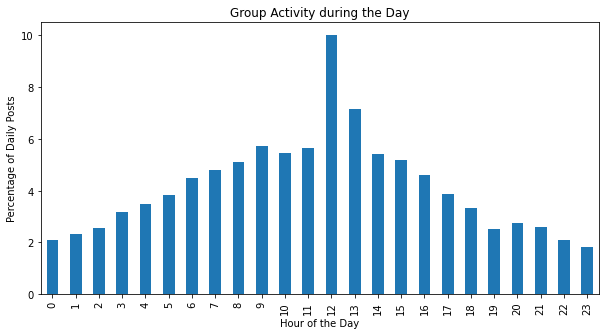

In [17]:
total_posts = summary_day['count'].sum()
summary_day\
    .sort_values('Hour_of_Day')\
    .apply(lambda x: x * 100 / total_posts if x.name == 'count' else x)\
    .plot.bar(x='Hour_of_Day', y='count', 
        title='Group Activity during the Day', 
        xlabel='Hour of the Day',
        ylabel='Percentage of Daily Posts',
        legend=False,
        figsize=(10, 5))

As one can see, there is a prominent peak in group activity at **13:00** hours UTC.

## 5. Determining the Most Mentioned Cryptocurrencies and their Temporal Evolution

### 5.1 Adding columns indicating if "Message" contains each currency

The top cryptocurrencies in terms of capitalization are taken, from https://coinmarketcap.com/. Here, a dictionary of possible ways users could refer to them is defined, assuming capitalized "Message". Common parts of words, like 'DOT' and 'ADA' need special care.

In [18]:
top_crypto = {'BTC': [' BTC ', 'BITCOIN', '$BTC'],
              'ETH': [' ETH ', 'ETHEREUM', '$ETH'],
              'XRP': [' XRP ', '$XRP'],
              'USDT': [' USDT ','TETHER', '$USDT'],
              'ADA': [' ADA ', 'CARDANO', '$ADA'],
              'DOT': [' DOT ', 'POLKADOT', 'POLKA', '$DOT'],
              'LTC': [' LTC ', 'LITECOIN', '$LTC'],
              'BNB': [' BNB ', 'BINANCE COIN', 'BINANCE', '$BNB'],
              'DOGE': [' DOGE ', 'DOGECOIN', '$DOGE'],
             }

In [19]:
for crypto in top_crypto.keys():
    column_name = 'Contains_' + crypto
    df = df.withColumn(column_name, lit(0))
    for c in top_crypto[crypto]:
        df = df.withColumn(column_name, when(upper(col('Message')).contains(c), 1).otherwise(col(column_name)))

df.select(['Message', 'Contains_DOT', 'Date']).filter('Contains_DOT == 1').limit(10).toPandas()

,Message,Contains_DOT,Date
0,"Hye, I see you can wd dot on heco chain , but I can’t find a app wallet to support receiving dot on heco chain, is it only for wd to metamask ?",1,2021-01-26
1,"Polkadot’s parachain communication (XCMP) and bridging mechanism, combined with the possibility to run solidity code on parachains such as Plasm, use native Ethereum addresses and huge ecosystem support (Web3, Parity) were the reasons why we chose to build on Polkadot. Reef being cross-chain gives us flexibility, which means we are able to shift our product and features based on where the users are (currently on Ethereum) and what the users want/need in the future.",1,2021-01-26
2,"You said that ""We need oracles both on Ethereum as well as on polkadot side"" but for this why you choose ""chainlink""? There are other platforms too which provide the same service? Why are you excited to work with them (Chainlink) thanks @denkomanceski",1,2021-01-26
3,Reef is a DeFi operating system powered by Polkadot. Can you please tell us what innovations and breakthroughs Reef is developing within the Polkadot ecosystem?,1,2021-01-26
4,"Polkadot ecosystem is sounds new for me, why Choosing build on this blockchain ?\nWhat is the advantage using Polkadot for Reef?",1,2021-01-26
5,what makes Reef different from metamask's trade feature? And will this coin have its own parachain in Polkadot?,1,2021-01-26
6,"Why is Reef using Polkadot's shared security model, and how has the Polkadot security model progressed, especially with the increasing preference of the Polkadot ecosystem in recent years?",1,2021-01-26
7,"Polkadot, Matic, Covalent ... I am sure this is only a small part of those who work now and will work in the future with Reef. But now it is becoming clear that the Reef team is striving not only to unite blockchains, but also to make the blockchain as transparent as possible for the user.Here they say: “I see the goal - I do not see obstacles.” What are the main goals of your team creating such a large-scale project? Is everything going as you planned in advance? And do you already see the finish line in your work, or there are no limits to perfection?))",1,2021-01-26
8,"#Polkadot is a multi-chain framework that supports interoperability between very different chains with various properties, including encrypted proof of authority chains suitable for internal business networks (as long as they confirm certain specifications) as #Reef finance integrates into this chain that allows us to do for the development of its technology?",1,2021-01-26
9,"Is the creation of the Polkadot DeFi Alliance more of a marketing ploy, or can you really agree on a decision that will simultaneously affect all the projects of the alliance?",1,2021-01-26


In [20]:
summary_contains = df\
    .select([col('Contains_' + c) for c in top_crypto.keys()])\
    .agg({'Contains_' + c: 'sum' for c in top_crypto.keys()})\
    .toPandas()\
    .T\
    .rename(columns={0:'Mentions'}, index={'sum(Contains_' + c + ')': c for c in top_crypto.keys()})

summary_contains

,Mentions
BNB,591
ADA,132
DOGE,118
BTC,2692
LTC,269
USDT,922
DOT,1046
XRP,249
ETH,1334


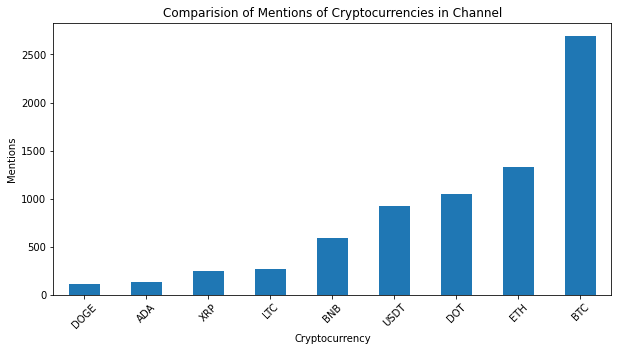

In [21]:
summary_contains\
    .sort_values('Mentions')\
    .plot.bar(y='Mentions',
        title='Comparision of Mentions of Cryptocurrencies in Channel', 
        xlabel='Cryptocurrency',
        ylabel='Mentions',
        legend=False,
        rot=45,
        figsize=(10, 5))

As we can see, **BTC** is by far the most discussed cryptocurrency, followed not too closely by USDT and ETH.

### 5.2 Observing the temporal evolution of a cryptocurrency's mentions

To this end, all that is necessary is to group the mentions by date, and to plot their evolutions.

In [22]:
grouped_by_date = df\
                    .select(['Date'] + ['Contains_' + c for c in top_crypto.keys()])\
                    .groupBy(col('Date'))\
                    .sum()\
                    .toPandas()\
                    .rename(columns={'sum(Contains_' + c + ')': c for c in top_crypto.keys()})\
                    .set_index('Date')
grouped_by_date

,BTC,ETH,XRP,USDT,ADA,DOT,LTC,BNB,DOGE
Date,,,,,,,,,
2021-01-27,1,0,0,4,1,0,0,0,0
2021-01-26,12,22,0,6,0,27,5,16,0
2021-01-25,11,6,0,5,4,1,0,8,0
2021-01-24,3,15,0,1,0,0,0,2,0
2021-01-23,5,2,0,7,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...
2019-05-31,4,1,0,0,0,0,0,0,1
2019-05-30,16,1,1,0,0,0,0,1,2
2019-05-29,13,0,1,0,1,0,0,1,0


Let's plot all the evolutions together first. This proves to be messy.

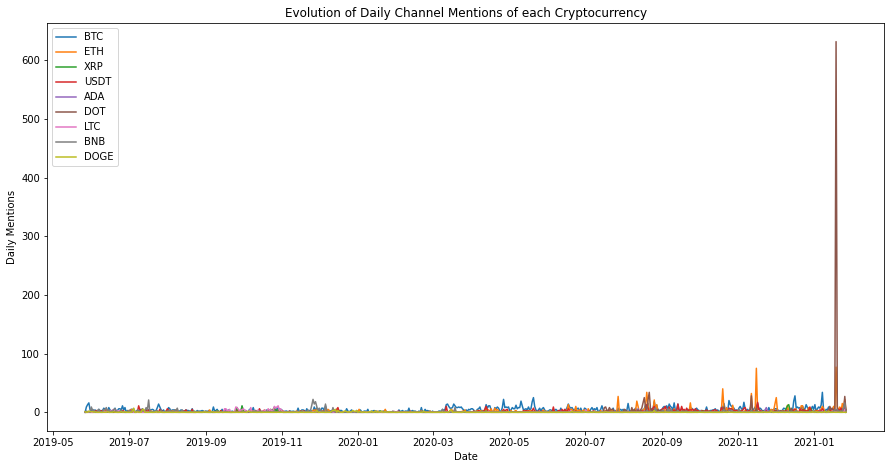

In [23]:
grouped_by_date.plot(figsize=(15, 7.5),
                     ylabel='Daily Mentions',
                     title='Evolution of Daily Channel Mentions of each Cryptocurrency')

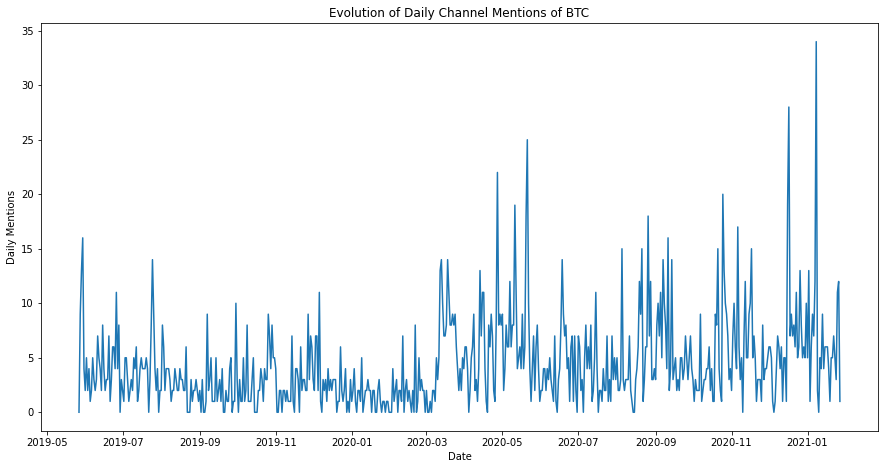

In [24]:
grouped_by_date['BTC'].plot(figsize=(15, 7.5),
                            ylabel='Daily Mentions',
                            title='Evolution of Daily Channel Mentions of BTC')

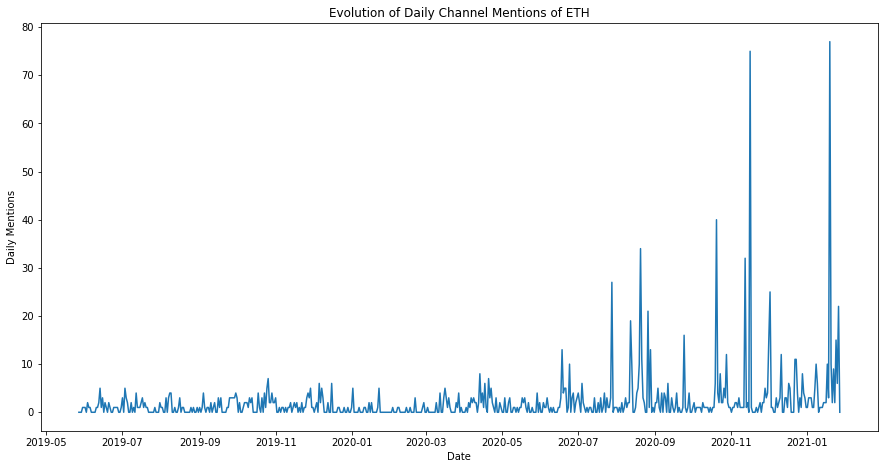

In [25]:
grouped_by_date['ETH'].plot(figsize=(15, 7.5),
                            ylabel='Daily Mentions',
                            title='Evolution of Daily Channel Mentions of ETH')

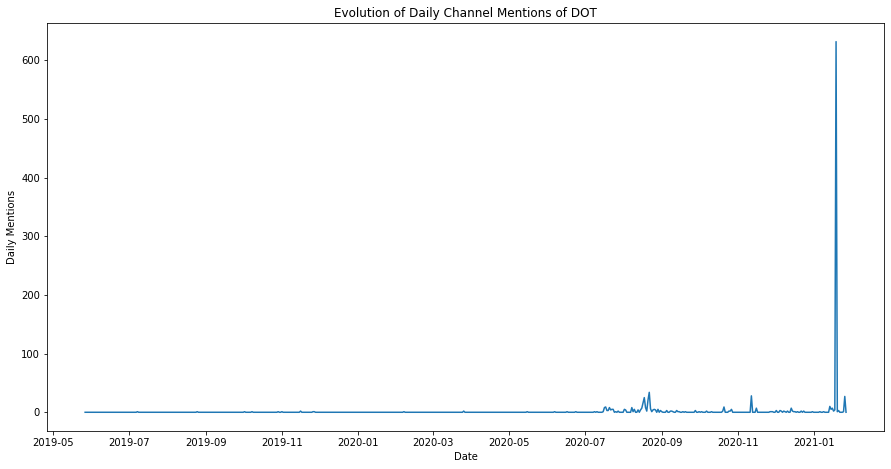

In [26]:
grouped_by_date['DOT'].plot(figsize=(15, 7.5),
                            ylabel='Daily Mentions',
                            title='Evolution of Daily Channel Mentions of DOT')

Something interesting must have happened with Polkadot in the end of January 2021. Perhaps some sort of spam.

### 5.3 Comparing the evolution of mentions with the price evolution

First, download the price data of each relevant cryptocurrency with `yfinance`. For this section, we will analyze only the following:
* BTC
* ETH
* DOT

In [27]:
tickers = ['BTC-USD', 'ETH-USD', 'DOT1-USD']
import yfinance as yf

In [28]:
prices = yf.download(tickers, start=grouped_by_date.index[-1], end=grouped_by_date.index[0])\
        .loc[:, 'Close']

[*********************100%***********************]  3 of 3 completed


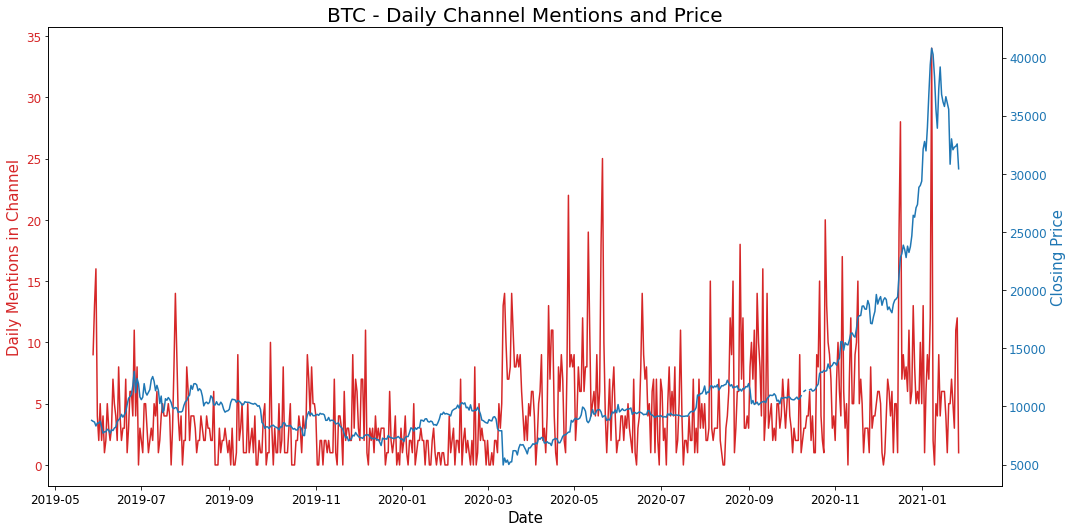

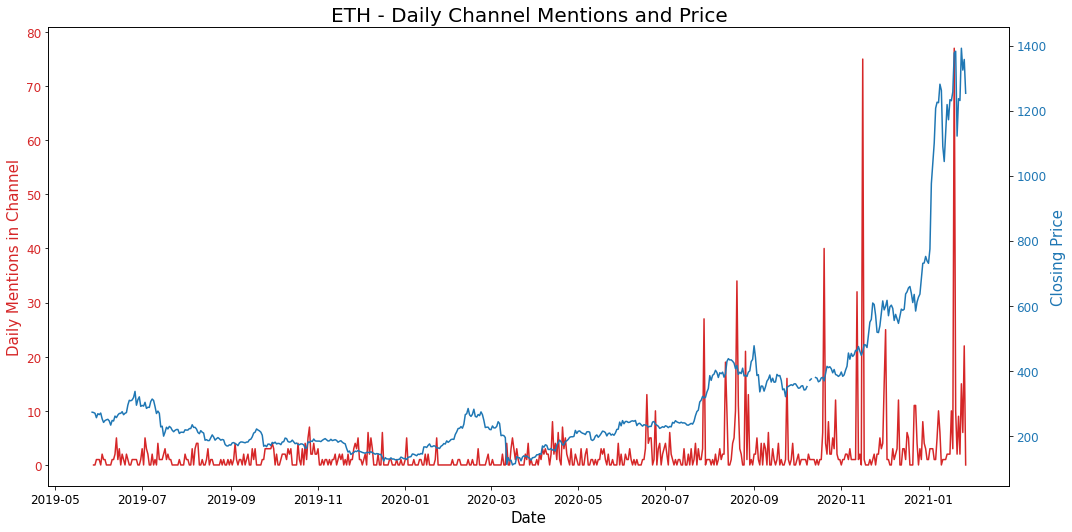

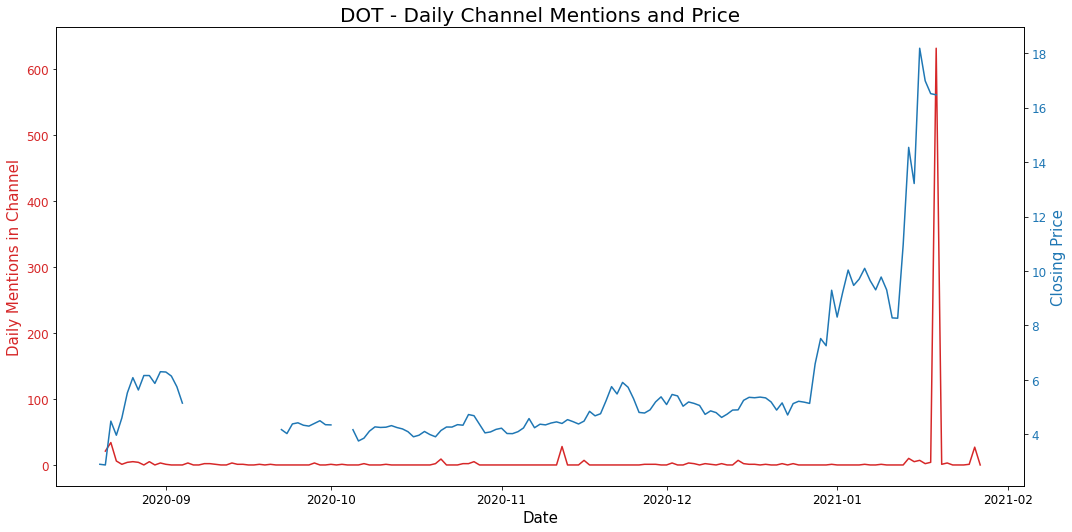

In [29]:
for i, crypto in enumerate(['BTC', 'ETH', 'DOT']): 
    
    start_date = prices[prices[tickers[i]].notna()].index[0]
    cut_price = prices.loc[prices.index > start_date, :]
    mentions_data = grouped_by_date.loc[grouped_by_date.index > start_date, :]
    
    fig, ax1 = plt.subplots()
    plt.title(crypto + ' - Daily Channel Mentions and Price', fontsize=20)
    fig.set_size_inches(15, 7.5)
    color = 'tab:red'
    ax1.set_xlabel('Date', fontsize=15)
    ax1.set_ylabel('Daily Mentions in Channel', color=color, fontsize=15)
    ax1.plot(mentions_data.index, mentions_data[crypto], color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Closing Price', color=color, fontsize=15) 
    ax2.plot(prices.index, prices[tickers[i]], color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=12)

    fig.tight_layout() 

We can definitely conclude that peaks in mentions come closely after quick rises in the price.

In [30]:
corr_mentions_prices = {}
for i, crypto in enumerate(['BTC', 'ETH', 'DOT']): 
    merged = pd.merge(grouped_by_date[crypto], prices[tickers[i]], left_index=True, right_index=True)
    corr_mentions_prices[crypto] = merged.corr().iloc[0, 1]
    
corr_mentions_prices

{'BTC': 0.2090317819865745,
 'DOT': 0.34051968827999746,
 'ETH': 0.28848294601341756}

## 6. Analyzing the Sentiment of Each Message

### 6.1 Isolating the words within each message

Before analyzing the sentiment of any message, it is necessary to split the message words into an array column. Special care is necessary to exclude `\n`, `,`, `?`, `!`, etc. from the original message string. Thus, a UDF is defined to carry out the task, and to make sure that no spaces are included in each word's string.

In [31]:
from pyspark.sql.types import ArrayType, FloatType, StringType

@udf(ArrayType(StringType()))
def clean_and_split_string(message):
    words = []
    if message is not None:
        unwanted = ['\n', ',', '?', '.', '!', ';', '¿', '¡']
        for patt in unwanted:
            message = message.replace(patt, ' ')
        words = [m.strip() for m in message.split(' ') if ((m != '') and (m != ' '))]
    return words

In [32]:
df_split = df.withColumn('Message_Words', clean_and_split_string(col('Message')))
df_split.select(['Message', 'Message_Words']).limit(20).toPandas()

,Message,Message_Words
0,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.","[I'm, confused, about, how, to, find, my, balance, which, I, transfer, to, futures, There, are, so, many, menus, and, I, can't, find, my, balance]"
1,⚠️ Important Reminder ☠️\n\n🚫 Huobi Global doesn't have any official customer support on Telegram. Admins and Huobi Knights will never ask you to make any form of payment or any personal and account related information for any reason. \n\n⁉️ If you need any kind of assistance related to your account please submit a ticket here (https://huobiglobal.zendesk.com/hc/de/requests/new). We will resolve your issue as soon as possible.,"[⚠️, Important, Reminder, ☠️, 🚫, Huobi, Global, doesn't, have, any, official, customer, support, on, Telegram, Admins, and, Huobi, Knights, will, never, ask, you, to, make, any, form, of, payment, or, any, personal, and, account, related, information, for, any, reason, ⁉️, If, you, need, any, kind, of, assistance, related, to, your, account, please, submit, a, ticket, here, (https://huobiglobal, zendesk, com/hc/de/requests/new), We, will, resolve, your, issue, as, soon, as, possible]"
2,Until when is the Kyc video review?,"[Until, when, is, the, Kyc, video, review]"
3,"Hello there welcome, how may I help you today?","[Hello, there, welcome, how, may, I, help, you, today]"
4,No,[No]
5,Hi guys,"[Hi, guys]"
6,"Hi team, are Huobi cooperate with NEUMEOKCA?","[Hi, team, are, Huobi, cooperate, with, NEUMEOKCA]"
7,Huobi team will never call you.\nStay safe,"[Huobi, team, will, never, call, you, Stay, safe]"
8,It's a typical scam call MD⚠️⚠️⚠️,"[It's, a, typical, scam, call, MD⚠️⚠️⚠️]"
9,"Hi, I got a call from a private number few hours back she was claiming to be from huobi and asked me if I'm still trading crypto and told my huobi account is inactive, wanted to know if it was from huobi or scam call","[Hi, I, got, a, call, from, a, private, number, few, hours, back, she, was, claiming, to, be, from, huobi, and, asked, me, if, I'm, still, trading, crypto, and, told, my, huobi, account, is, inactive, wanted, to, know, if, it, was, from, huobi, or, scam, call]"


It is necessary to make sure that the UDF's output is specified correctly.

In [33]:
df_split.printSchema()

root
 |-- Post_ID: long (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Message: string (nullable = true)
 |-- Author_ID: long (nullable = true)
 |-- Date: date (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Hour_of_Day: integer (nullable = true)
 |-- Contains_BTC: integer (nullable = false)
 |-- Contains_ETH: integer (nullable = false)
 |-- Contains_XRP: integer (nullable = false)
 |-- Contains_USDT: integer (nullable = false)
 |-- Contains_ADA: integer (nullable = false)
 |-- Contains_DOT: integer (nullable = false)
 |-- Contains_LTC: integer (nullable = false)
 |-- Contains_BNB: integer (nullable = false)
 |-- Contains_DOGE: integer (nullable = false)
 |-- Message_Words: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [34]:
df_split = df_split.withColumn('Single_Word', explode(col('Message_Words')))
df_split.select(['Message', 'Message_Words', 'Single_Word']).limit(10).toPandas()

,Message,Message_Words,Single_Word
0,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.","[I'm, confused, about, how, to, find, my, balance, which, I, transfer, to, futures, There, are, so, many, menus, and, I, can't, find, my, balance]",I'm
1,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.","[I'm, confused, about, how, to, find, my, balance, which, I, transfer, to, futures, There, are, so, many, menus, and, I, can't, find, my, balance]",confused
2,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.","[I'm, confused, about, how, to, find, my, balance, which, I, transfer, to, futures, There, are, so, many, menus, and, I, can't, find, my, balance]",about
3,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.","[I'm, confused, about, how, to, find, my, balance, which, I, transfer, to, futures, There, are, so, many, menus, and, I, can't, find, my, balance]",how
4,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.","[I'm, confused, about, how, to, find, my, balance, which, I, transfer, to, futures, There, are, so, many, menus, and, I, can't, find, my, balance]",to
5,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.","[I'm, confused, about, how, to, find, my, balance, which, I, transfer, to, futures, There, are, so, many, menus, and, I, can't, find, my, balance]",find
6,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.","[I'm, confused, about, how, to, find, my, balance, which, I, transfer, to, futures, There, are, so, many, menus, and, I, can't, find, my, balance]",my
7,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.","[I'm, confused, about, how, to, find, my, balance, which, I, transfer, to, futures, There, are, so, many, menus, and, I, can't, find, my, balance]",balance
8,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.","[I'm, confused, about, how, to, find, my, balance, which, I, transfer, to, futures, There, are, so, many, menus, and, I, can't, find, my, balance]",which
9,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.","[I'm, confused, about, how, to, find, my, balance, which, I, transfer, to, futures, There, are, so, many, menus, and, I, can't, find, my, balance]",I


### 6.2 Introducing the Sentiment Dictionary

The sentiment dictionary used to analyze message sentiment has been obtained from the individual assignment of the course _Introduction to Big Data Architectures_. This dictionary consists of a TSV file with the following fields:
* type: string
* length: always 1
* word: string defining the actual word
* word_type: string defining the word type 
* stemmed: string, either 'y' or 'n'
* polarity: string, either 'positive' or 'negative'


Let's load the file and get it ready for analysis.

In [35]:
sentiment = spark.read.csv('/content/drive/MyDrive/Spark/Individual Assignment/dictionary.tsv', sep=r'\t', header=True)\
            .select(['word', 'polarity'])\
            .withColumn('polarity', when(col('polarity') == 'negative', -1)\
                                    .when(col('polarity') == 'positive', 1)\
                                    .otherwise(0))
sentiment.limit(10).toPandas()

,word,polarity
0,abandoned,-1
1,abandonment,-1
2,abandon,-1
3,abase,-1
4,abasement,-1
5,abash,-1
6,abate,-1
7,abdicate,-1
8,aberration,-1
9,aberration,-1


### 6.3 Calcuating the sentiment of each message

First, it is necessary to join `sentiment` with `df_split` on `Single_Word == word`.

In [36]:
post_polarity = df_split\
    .join(sentiment, df_split.Single_Word == sentiment.word, 'left')\
    .groupBy('Post_ID')\
    .agg({'polarity': 'avg'})\
    .withColumnRenamed('avg(polarity)', 'Polarity')\
    .fillna(0)
post_polarity.limit(10).toPandas()

,Post_ID,Polarity
0,1018086,1.000000
1,1017424,0.000000
2,1016249,0.000000
3,1016130,0.000000
4,1016056,1.000000
5,1016047,0.571429
6,1015454,-0.666667
7,1014918,1.000000
8,1014647,0.000000
9,1014336,0.000000


In [37]:
df = df.join(post_polarity, 'Post_ID')
df.limit(10).toPandas()

,Post_ID,Timestamp,Message,Author_ID,Date,Day_of_Week,Hour_of_Day,Contains_BTC,Contains_ETH,Contains_XRP,Contains_USDT,Contains_ADA,Contains_DOT,Contains_LTC,Contains_BNB,Contains_DOGE,Polarity
0,452425,2019-05-28T08:49:05+00:00,Hi admin,725813576,2019-05-28,3,8,0,0,0,0,0,0,0,0,0,0.0
1,454372,2019-05-28T09:35:42+00:00,Good morning,412158901,2019-05-28,3,9,0,0,0,0,0,0,0,0,0,0.0
2,464762,2019-05-28T14:54:43+00:00,"Дмитрий, [28.05.19 19:54]\nN 55.7965°\nE 49.1082°",869278982,2019-05-28,3,14,0,0,0,0,0,0,0,0,0,0.0
3,466447,2019-05-28T15:42:25+00:00,/,286855716,2019-05-28,3,15,0,0,0,0,0,0,0,0,0,0.0
4,468818,2019-05-28T17:03:25+00:00,Hi,695802351,2019-05-28,3,17,0,0,0,0,0,0,0,0,0,0.0
5,469506,2019-05-28T17:36:28+00:00,hi,640235457,2019-05-28,3,17,0,0,0,0,0,0,0,0,0,0.0
6,470136,2019-05-28T18:11:22+00:00,Ok i did,537012799,2019-05-28,3,18,0,0,0,0,0,0,0,0,0,0.0
7,470755,2019-05-28T18:44:52+00:00,Hey guys,572208486,2019-05-28,3,18,0,0,0,0,0,0,0,0,0,0.0
8,475117,2019-05-29T01:54:54+00:00,/claim,661942209,2019-05-29,4,1,0,0,0,0,0,0,0,0,0,0.0
9,477628,2019-05-29T06:05:21+00:00,Hi,746649478,2019-05-29,4,6,0,0,0,0,0,0,0,0,0,0.0


### 6.4 Analyzing the evolution of sentiment

Besides grouping by day, let's use a rolling average to obtain a less noisy curve. Usage of `Window()` inspired by https://stackoverflow.com/questions/45806194/pyspark-rolling-average-using-timeseries-data

In [38]:
from pyspark.sql.window import Window
w = Window.orderBy('Date').rowsBetween(-7, 0)

daily_sentiment = df\
                    .select(['Date', 'Polarity'])\
                    .groupBy('Date')\
                    .avg()\
                    .withColumnRenamed('avg(Polarity)', 'Daily_Polarity')\
                    .withColumn('Rolling_Daily_Polarity', avg(col('Daily_Polarity')).over(w))\
                    .toPandas()\
                    .set_index('Date')

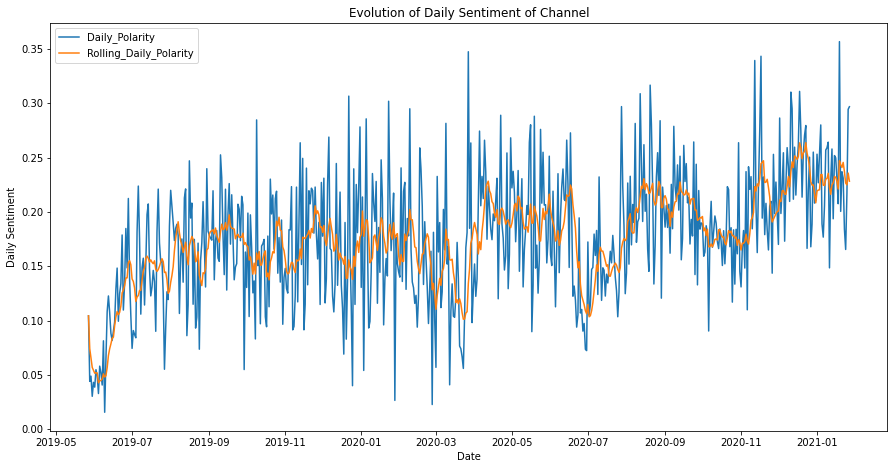

In [39]:
daily_sentiment.plot(figsize=(15, 7.5),
                    ylabel='Daily Sentiment',
                    title='Evolution of Daily Sentiment of Channel')

Now let's compare the evolution in sentiment with the prices of the relevant cryptocurrencies.

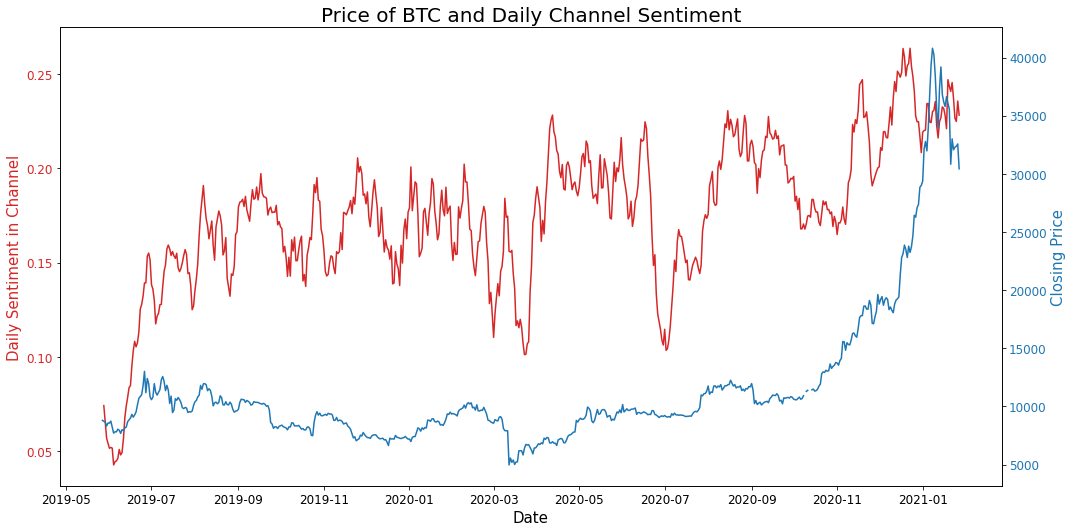

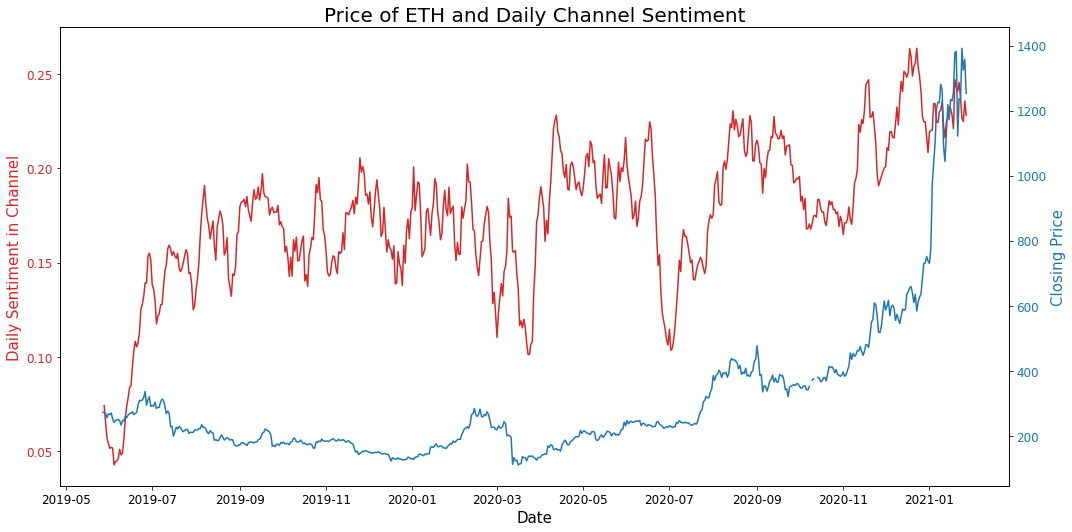

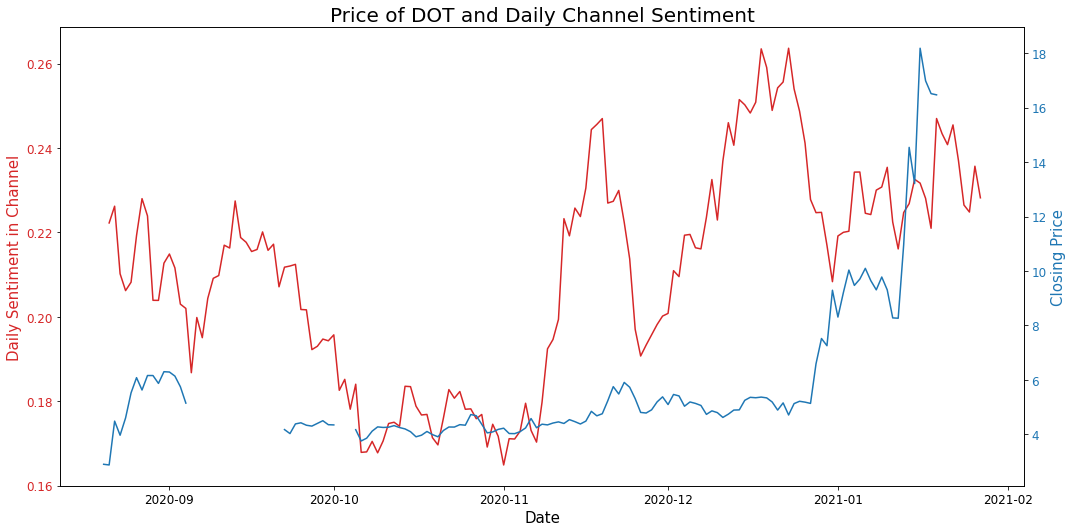

In [40]:
for i, crypto in enumerate(['BTC', 'ETH', 'DOT']): 
    
    start_date = prices[prices[tickers[i]].notna()].index[0]
    cut_price = prices.loc[prices.index > start_date, :]
    sentiment_data = daily_sentiment.loc[daily_sentiment.index > start_date, 'Rolling_Daily_Polarity']
    
    fig, ax1 = plt.subplots()
    plt.title('Price of ' + crypto + ' and Daily Channel Sentiment', fontsize=20)
    fig.set_size_inches(15, 7.5)
    color = 'tab:red'
    ax1.set_xlabel('Date', fontsize=15)
    ax1.set_ylabel('Daily Sentiment in Channel', color=color, fontsize=15)
    ax1.plot(sentiment_data.index, sentiment_data, color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Closing Price', color=color, fontsize=15) 
    ax2.plot(prices.index, prices[tickers[i]], color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=12)

    fig.tight_layout() 

It is visible that in the last days of the analysis, the channel sentiment is up! This is most likely due to a growth in the prices of BTC and ETH.

In [41]:
corr_sentiment_prices = {}
for i, crypto in enumerate(['BTC', 'ETH', 'DOT']): 
    merged = pd.merge(daily_sentiment['Rolling_Daily_Polarity'], prices[tickers[i]], left_index=True, right_index=True)
    corr_sentiment_prices[crypto] = merged.corr().iloc[0, 1]
    corr_mentions_prices = {}
corr_sentiment_prices

{'BTC': 0.5123653328557044,
 'DOT': 0.36687696171957856,
 'ETH': 0.49343354469932516}

## 7. Sentiment Analysis with Spark NLP

### 7.1 Additional Libraries

In [42]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

### 7.2 Employed Pipeline

Before Spark NLP can be used to further analyze the dataframe of channel messages, the following preprocessing steps are required:
1. Casting the "Message" column as DocumentType.
2. Tokenizing each message, obtaining an array column of words.
3. Normalizing the tokenized message, eliminating punctuation marks and other undesired characters.
4. Elminating stopwords (like "the", "to", "in", etc.) from the tokenized, normalized message.
5. Lemmatizing the resulting message, to reduce each word to its core meaning.
6. Vectorize each tokenized message, by means of the corresponding word embedding method.
7. Obtain the corresponding sentence embeddings.

All these steps can be defined within a Pipeline. For a sentiment analysis of the original dataframe, the last step of this Pipeline is a sentiment classifier.

In [43]:
document_assembler = DocumentAssembler()\
                    .setInputCol("Message")\
                    .setOutputCol("Document")
 
tokenizer = Tokenizer()\
            .setInputCols(["Document"])\
            .setOutputCol("Token")
    
normalizer = Normalizer()\
            .setInputCols(["Token"])\
            .setOutputCol("Normalized")\
            .setLowercase(True)

stopwords_cleaner = StopWordsCleaner()\
                    .setInputCols("Normalized")\
                    .setOutputCol("Clean_Tokens")\
                    .setCaseSensitive(False)

lemma = LemmatizerModel\
        .pretrained('lemma_antbnc')\
        .setInputCols(["Clean_Tokens"])\
        .setOutputCol("Lemma")

vivekn_sentiment = ViveknSentimentModel\
                  .pretrained('sentiment_vivekn')\
                  .setInputCols(["Lemma", "Document"])\
                  .setOutputCol("Sentiment")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
[OK!]


In [44]:
sentiment_pipeline = Pipeline(stages = [
                              document_assembler,
                              tokenizer,
                              normalizer,
                              stopwords_cleaner,
                              lemma,
                              vivekn_sentiment
])

### 7.3 Obtaining message sentiment with the defined Pipeline

Since the original dataframe may contain empty or very short messages, which result in empty tokenized versions after the pipeline, it is necessary to drop these posts beforehand.

In [45]:
df_pure = df_pure.withColumn('Text_Length', length(col('Message'))).filter("Text_Length > 10")

df_pure = sentiment_pipeline.fit(df_pure).transform(df_pure)

In [46]:
df_pure = df_pure\
          .withColumn('Polarity', 
                      when(col("Sentiment.result")[0] == 'positive', 1)\
                      .when(col("Sentiment.result")[0] == 'negative', -1)\
                      .otherwise(0))\
          .withColumn('Date', to_date(col('Timestamp')))

df_pure.select(['Date', 'Message', "Lemma.result", 'Polarity']).limit(5).toPandas()

,Date,Message,result,Polarity
0,2021-01-27,"I'm confused about how to find my balance, which I transfer to futures. There are so many menus and I can't find my balance.","[im, confused, find, balance, transfer, future, many, menu, cant, find, balance]",1
1,2021-01-27,⚠️ Important Reminder ☠️\n\n🚫 Huobi Global doesn't have any official customer support on Telegram. Admins and Huobi Knights will never ask you to make any form of payment or any personal and account related information for any reason. \n\n⁉️ If you need any kind of assistance related to your account please submit a ticket here (https://huobiglobal.zendesk.com/hc/de/requests/new). We will resolve your issue as soon as possible.,"[important, reminder, huobi, global, doesnt, official, customer, support, telegram, admin, huobi, knight, never, ask, make, form, payment, personal, account, relate, information, reason, need, kind, assistance, relate, account, please, submit, ticket, httpshuobiglobalzendeskcomhcderequestsnew, resolve, issue, soon, possible]",1
2,2021-01-27,Until when is the Kyc video review?,"[kyc, video, review]",-1
3,2021-01-27,"Hello there welcome, how may I help you today?","[hello, welcome, may, help, today]",-1
4,2021-01-27,"Hi team, are Huobi cooperate with NEUMEOKCA?","[hi, team, huobi, cooperate, neumeokca]",1


### 7.4 Calculating the daily evolution of sentiment

In [47]:
from pyspark.sql.window import Window
w = Window.orderBy('Date').rowsBetween(-7, 0)

daily_sentiment_vivkn = df_pure\
                        .select(['Date', 'Polarity'])\
                        .groupBy('Date')\
                        .avg()\
                        .withColumnRenamed('avg(Polarity)', 'Daily_Polarity')\
                        .withColumn('Rolling_Daily_Polarity', avg(col('Daily_Polarity')).over(w))\
                        .toPandas()\
                        .set_index('Date')

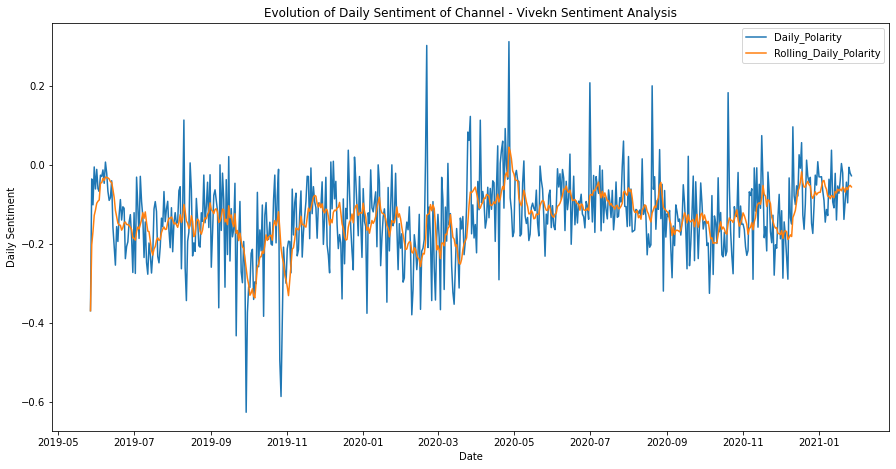

In [48]:
daily_sentiment_vivkn.plot(figsize=(15, 7.5),
                    ylabel='Daily Sentiment',
                    title='Evolution of Daily Sentiment of Channel - Vivekn Sentiment Analysis')

Let's compare this sentiment evolution with the one obtained via a simple sentiment dictionary.

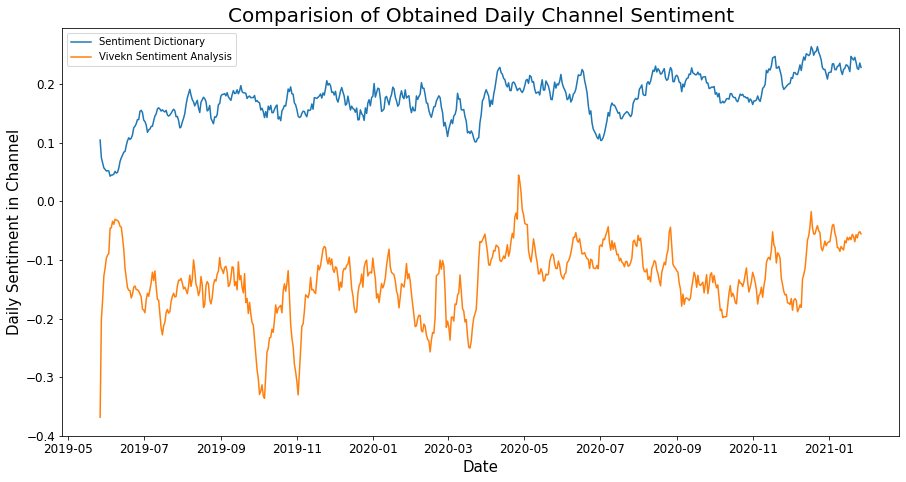

In [49]:
fig, ax = plt.subplots()
plt.title('Comparision of Obtained Daily Channel Sentiment', fontsize=20)
fig.set_size_inches(15, 7.5)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Daily Sentiment in Channel', fontsize=15)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

ax.plot(daily_sentiment.index, daily_sentiment['Rolling_Daily_Polarity'], label='Sentiment Dictionary')
ax.plot(daily_sentiment_vivkn.index, daily_sentiment_vivkn['Rolling_Daily_Polarity'], label='Vivekn Sentiment Analysis')
ax.legend()

Now let's examine the evolution of each relevant cryptocurrency price next to this sentiment evolution.

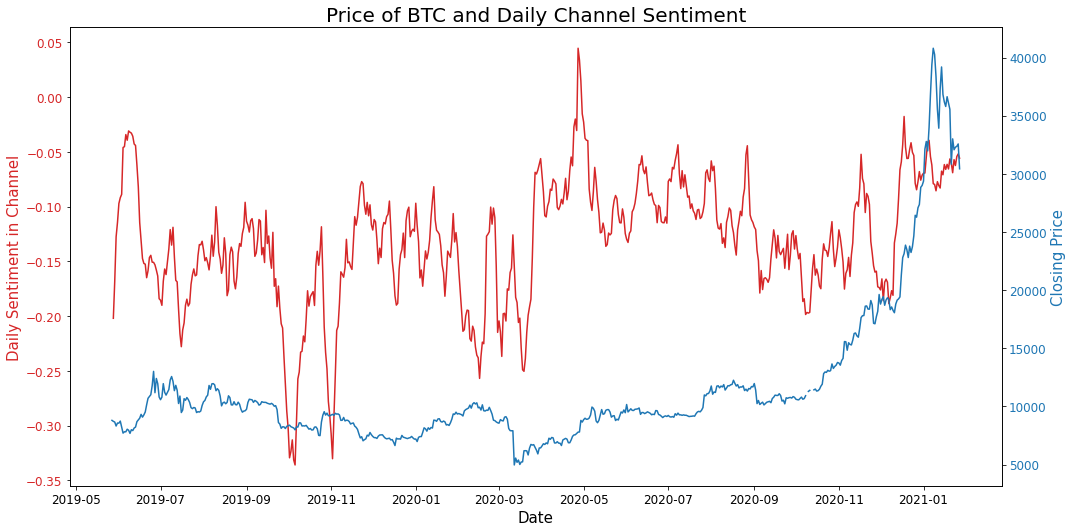

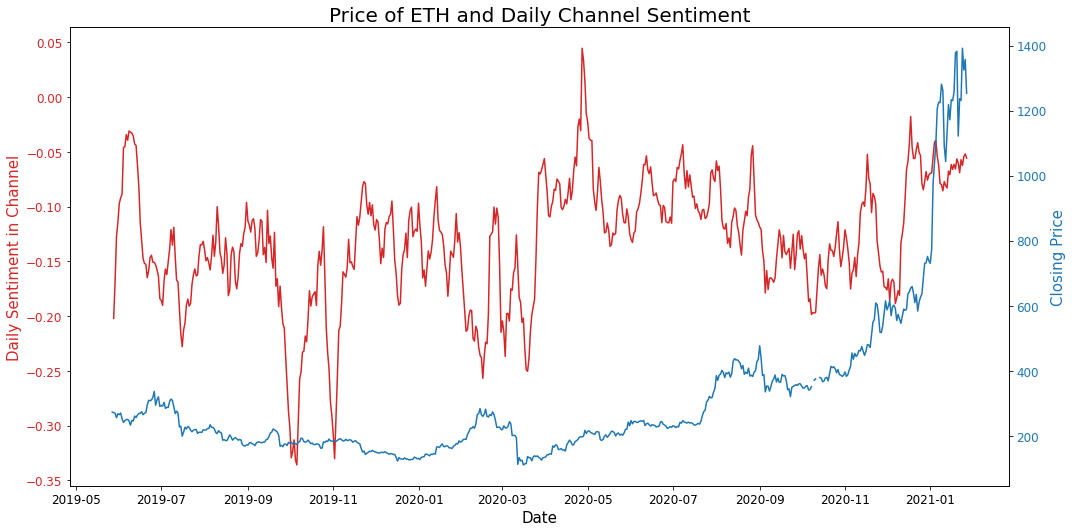

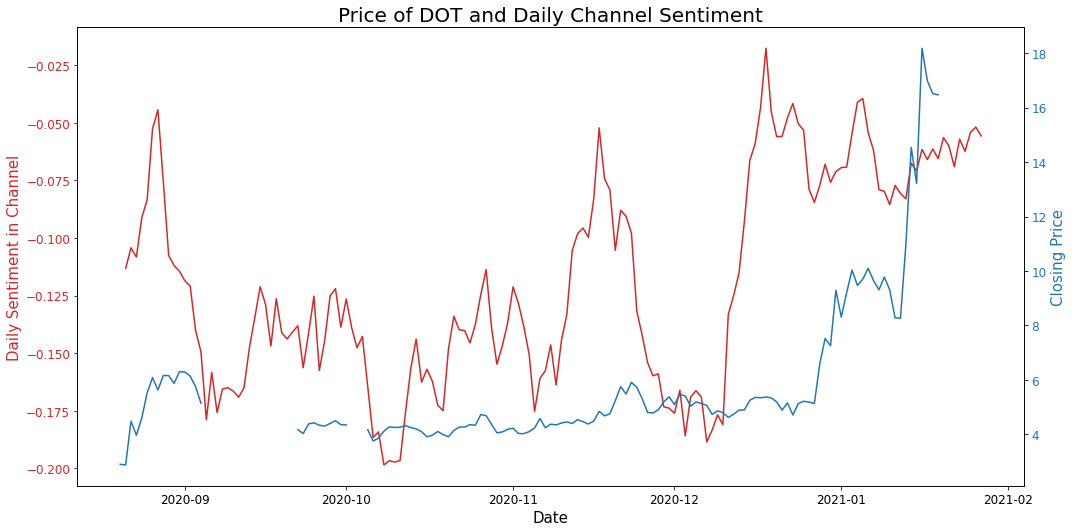

In [50]:
for i, crypto in enumerate(['BTC', 'ETH', 'DOT']): 
    
    start_date = prices[prices[tickers[i]].notna()].index[0]
    cut_price = prices.loc[prices.index > start_date, :]
    sentiment_data = daily_sentiment_vivkn.loc[daily_sentiment_vivkn.index > start_date, 'Rolling_Daily_Polarity']
    
    fig, ax1 = plt.subplots()
    plt.title('Price of ' + crypto + ' and Daily Channel Sentiment', fontsize=20)
    fig.set_size_inches(15, 7.5)
    color = 'tab:red'
    ax1.set_xlabel('Date', fontsize=15)
    ax1.set_ylabel('Daily Sentiment in Channel', color=color, fontsize=15)
    ax1.plot(sentiment_data.index, sentiment_data, color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Closing Price', color=color, fontsize=15) 
    ax2.plot(prices.index, prices[tickers[i]], color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=12)

    fig.tight_layout() 

## 8. Predicting Price Evolution based on Messages with a NN

The objective of this section is to apply word and sentence embeddings as the input of a neural network, predicting whether BTC prices rise or fall.

### 8.1 Defining the target to predict

In [51]:
price_evolution = prices[['BTC-USD']].diff()[1:]
price_evolution['Rising'] = price_evolution['BTC-USD'].apply(lambda x: 1 if x > 0 else 0)
price_evolution = price_evolution.reset_index().drop(columns=['BTC-USD'])

schema = StructType([StructField('Date',DateType(),True), StructField('Rising',IntegerType(),True)])
price_evolution=spark.createDataFrame(price_evolution, schema)
price_evolution.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Rising: integer (nullable = true)



In [52]:
df_pure = df_pure.join(price_evolution, 'Date')
df_pure.select(['Date', 'Rising']).limit(10).toPandas()

,Date,Rising
0,2019-05-28,0
1,2019-05-28,0
2,2019-05-28,0
3,2019-05-28,0
4,2019-05-28,0
5,2019-05-28,0
6,2019-05-28,0
7,2019-05-28,0
8,2019-05-28,0
9,2019-05-28,0


### 8.2 Defining the Pipeline to be used
In this step, the same stages as in the previous preprocessing are used, but with an additional layer of word and sentence embedding.

In [53]:
glove_embeddings = WordEmbeddingsModel().pretrained()\
                  .setInputCols(["Document",'Lemma'])\
                  .setOutputCol("Embeddings")\
                  .setCaseSensitive(False)

sentence_embeddings = SentenceEmbeddings()\
                    .setInputCols(["Document", "Embeddings"])\
                    .setOutputCol("Sentence_Embeddings")\
                    .setPoolingStrategy("AVERAGE")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [54]:
predictor_pipeline = Pipeline(stages = [
                              document_assembler,
                              tokenizer,
                              normalizer,
                              stopwords_cleaner,
                              lemma,
                              vivekn_sentiment,
                              glove_embeddings,
                              sentence_embeddings
])

In [55]:
df_pure = predictor_pipeline.fit(df_pure).transform(df_pure)

### 8.3 Constructing the NN with PyTorch

In [ ]:
! pip install torch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

To train the NN, a Dataset object is defined, which is to store the word embeddings from the Pipeline. Also, the constructor for the net is implemented, with the number of layers and neurons in each layer being specified at the object construction.

In [ ]:
class Data(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float, requires_grad=True)#torch.FloatTensor(X, requires_grad = True)
    self.y = torch.tensor(y, dtype=torch.long)#dtype=torch.long)#torch.LongTensor(y, requires_grad = True)
    self.len = len(y)
            
  def __getitem__(self, index):
    X = self.X[index]
    y = self.y[index]
    return X, y
    
  def __len__(self):
    return self.len

In [ ]:
class Net(nn.Module):
    
  def __init__(self, Layers):
    super(Net, self).__init__()
    self.hidden = nn.ModuleList()
    for input_size, output_size in zip(Layers, Layers[1:]):
      self.hidden.append(nn.Linear(input_size, output_size))
    
  def forward(self, activation):
    L = len(self.hidden)
    for (l, linear_transform) in zip(range(L), self.hidden):
      if l < L - 1:
        activation = F.relu(linear_transform(activation))    
      else:
        activation = linear_transform(activation)
    return activation

We define now a function for calculating the accuracy of a NN for a given dataset.

In [ ]:
def accuracy(model, data_set):
  _, yhat = torch.max(model(data_set.X), 1)
  return (yhat == data_set.y).numpy().mean()

Now, it is also possible to define a function which trains the NN.

In [ ]:
def train(model, train_data, test_data, criterion, train_loader, optimizer, epochs=500):
    LOSS = []
    ACC_TRAIN = []
    ACC_TEST = []
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y.type(torch.LongTensor))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        acc_train = accuracy(model, train_data)
        acc_test = accuracy(model, test_data)
        print(f'Epoch: {epoch} - Training Accuracy = {acc_train}, Test Accuracy = {acc_test}, Loss = {loss.item()}')
        LOSS.append(loss.item())
        ACC_TRAIN.append(acc_train)
        ACC_TEST.append(acc_test)
        
    results ={'Loss': LOSS, 'Training Accuracy': ACC_TRAIN, 'Test Accuracy': ACC_TEST}

    fig, ax = plt.subplots()
    plt.title('Evolution of Loss during Training', fontsize=20)
    fig.set_size_inches(15, 7.5)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_ylabel('Loss', fontsize=15)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.plot(LOSS)
    
    fig, ax = plt.subplots()
    plt.title('Evolution of Accuracy during Training', fontsize=20)
    fig.set_size_inches(15, 7.5)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.plot(ACC_TRAIN, label='Training Accuracy')
    ax.plot(ACC_TEST, label='Test Accuracy')
    ax.legend()
    
    plt.show()
    return results

### 8.4 Preparing the Training

In [ ]:
data = df_pure\
      .withColumn('Vector', flatten(col('Sentence_Embeddings.embeddings')))\
      .where(size(col('Vector')) == 100)\
      .select(['Date', "Vector", 'Rising']).limit(100000)
train_size = int(0.8 * data.count())

X = data.select('Vector').toPandas()['Vector'].tolist()
X_train = X[:train_size]
X_test = X[train_size:]

y = data.select('Rising').toPandas()['Rising'].tolist()
y_train = y[:train_size]
y_test = y[train_size:]

In [ ]:
Layers = [100, 50, 50, 2]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_data = Data(X_train, y_train)
test_data = Data(X_test, y_test)
train_loader = DataLoader(dataset=train_data, batch_size=100)
criterion = nn.CrossEntropyLoss()

### 8.5 Training the Model

In [ ]:
results = train(model, train_data, test_data, criterion, train_loader, optimizer)

Epoch: 0 - Training Accuracy = 0.5070625, Test Accuracy = 0.47795, Loss = 0.7498105764389038
Epoch: 1 - Training Accuracy = 0.5059375, Test Accuracy = 0.4705, Loss = 0.7596176266670227
Epoch: 2 - Training Accuracy = 0.5061, Test Accuracy = 0.471, Loss = 0.7606955766677856
Epoch: 3 - Training Accuracy = 0.506525, Test Accuracy = 0.47045, Loss = 0.7598862648010254
Epoch: 4 - Training Accuracy = 0.5066875, Test Accuracy = 0.4709, Loss = 0.7592661380767822
Epoch: 5 - Training Accuracy = 0.5071875, Test Accuracy = 0.47225, Loss = 0.7576854825019836
Epoch: 6 - Training Accuracy = 0.5119125, Test Accuracy = 0.47555, Loss = 0.7533047199249268
Epoch: 7 - Training Accuracy = 0.4942875, Test Accuracy = 0.4705, Loss = 0.7511656880378723
Epoch: 8 - Training Accuracy = 0.4986625, Test Accuracy = 0.4731, Loss = 0.7492492198944092
Epoch: 9 - Training Accuracy = 0.4989625, Test Accuracy = 0.4748, Loss = 0.7484575510025024
Epoch: 10 - Training Accuracy = 0.5011875, Test Accuracy = 0.4756, Loss = 0.74774

KeyboardInterrupt: ignored

Whereas implementing the classifier NN with PyTorch allows for a great level of control over the training process, it has proven to take a very long time, even for less than half of the original dataset. Given the abundance of ML tools which Spark provides, it makes sense to give them a try.

## 9. Predicting Price Evolution based on Messages with a NLP Classifier

### 9.1 Defining the new Approach

Here, ClassifierDL from Spark NLP is used, in order to predict whether each message is associated to a rise or a fall in the price of BTC.

In [56]:
classifier = ClassifierDLApproach()\
    .setInputCols(["Sentence_Embeddings"])\
    .setOutputCol("Prediction")\
    .setLabelColumn("Rising")\
    .setMaxEpochs(3)

### 9.2 Splitting into testing and training datasets

In [57]:
df_train = df_pure.withColumn("index", monotonically_increasing_id()).where(col('index') < 200000).drop("index")
df_test= df_pure.withColumn("index", monotonically_increasing_id()).where(col('index') > 200000).drop("index")

### 9.3 Fitting the model

In [58]:
clf_model = classifier.fit(df_train)

### 9.4 Evaluating model predictions

In [59]:
df_predictions = clf_model.transform(df_test)

In [60]:
df_predictions.withColumn('Prediction_Int', col('Prediction.result').getItem(0).cast('int')).select('Prediction_Int').limit(50).toPandas()

,Prediction_Int
0,0
1,0
2,1
3,1
4,1
5,1
6,0
7,0
8,1
9,0


In [61]:
confusion = df_predictions\
                          .withColumn('Prediction_Int', col('Prediction.result').getItem(0).cast('int'))\
                          .withColumn('TP',
                                      when((col('Prediction_Int') == 1) & (col('Rising') == 1), 1).otherwise(0))\
                          .withColumn('FP',
                                      when((col('Prediction_Int') == 1) & (col('Rising') == 0), 1).otherwise(0))\
                          .withColumn('TN',
                                      when((col('Prediction_Int') == 0) & (col('Rising') == 0), 1).otherwise(0))\
                          .withColumn('FN',
                                      when((col('Prediction_Int') == 0) & (col('Rising') == 1), 1).otherwise(0))\
                          .withColumn('Total', lit(1))\
                          .select([sum(col(c)).alias(c) for c in ['TP', 'FP', 'TN', 'FN', 'Total']])


In [62]:
conf = confusion.toPandas()

In [70]:
print(f"Accuracy = {((conf['TP'] + conf['TN']) * 100 / conf['Total'])[0]:.3f} %,   Precision = {((conf['TP']) * 100 / (conf['TP'] + conf['FP']))[0]:.3f} %,   Recall = {((conf['TP']) * 100 / (conf['TP'] + conf['FN']))[0]:.3f} %")

Accuracy = 47.612 %,   Precision = 54.936 %,   Recall = 33.280 %


Although it was fairly dubious from the start that a robust prediction was achievable, given the noisy nature of the price data, this classifier could be improved by:
* Adding more data from multiple channels
* Smoothing the price curve
* Testing different word embeddings
* Testing/customizing more classifier variations